# Mixture of Gaussian Likelihood

In [30]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import scipy

# For ABC
import pyabc
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scipy
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

Given mean shifts $[a_1,...,a_{n}]$, weights $[w_1,...,w_n]$ (that are nonnegative and sum to 1) and a prior variance $\sigma^2>0$, we define our prior and likelihood:

$$p(\theta) \sim N(0,\sigma^2)$$

$$p(x|\theta) \sim \sum_{i=1}^{n} w_i N(x; \theta + a_i, 1)$$

We can calculate the corresponding posterior and evidence in closed form:

$$p(x) = \int p(x|\theta)p(\theta)d\theta = \frac{1}{\sqrt{2\pi(1+\sigma^2)}} \sum_{i=1}^{n} w_i e^{-\frac{(x-a_i)^2}{2(1+\sigma^2)}} = \sum_{i=1}^{n}w_i N(x;a_i,1+\sigma^2)$$

$$p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)} =
\frac{1}{\sqrt{2\pi(1+\sigma^2)}}\sum_{i=1}^{n} 
w_i e^{-\frac{(x-a_i)^2}{2(1+\sigma^2)}} 
e^{-\frac{1+\sigma^2}{2\sigma^2}\left(\theta-\frac{\sigma^2(x-a_i)}{1+\sigma^2}\right)^2}
= \sum_{i=1}^{n}  w_i N\left(\theta;\frac{\sigma^2(x-a_i)}{1+\sigma^2},\frac{\sigma^2}{1+\sigma^2}\right)$$


In [ ]:
from src.examples.mog_1d import prior_pdf, likelihood_pdf, posterior_pdf

### Define weights, mean shifts and prior variance:

In [46]:
sigma = 5
weights = [0.3,0.2,0.1,0.3,0.1]
mean_shifts = [-20,-4,2,12,11]

# For plotting
x_range = np.linspace(-20,20,1000)
theta_range = np.linspace(-20,20,1000)

### Likelihood Plot

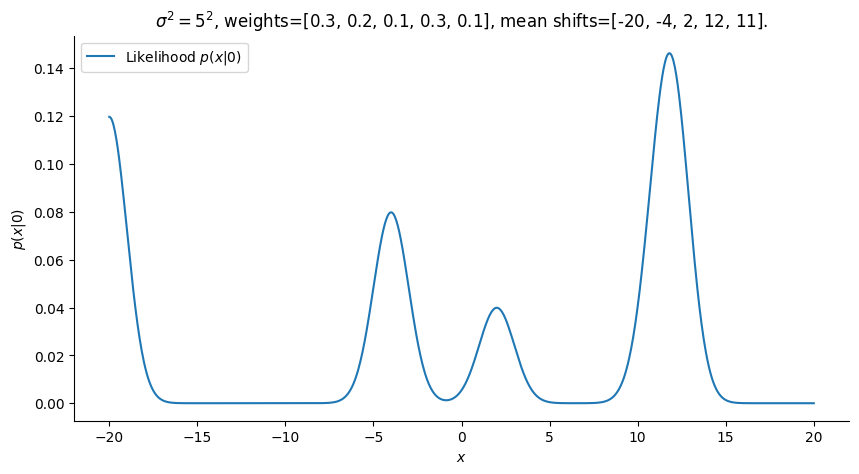

In [54]:
true_theta = 0
fig, ax = plt.subplots(figsize=(10,5))
label = fr"Likelihood $p(x|{true_theta})$"
ax.plot(x_range, likelihood_pdf(x_range, true_theta, weights, mean_shifts), label=label)
ax.set_xlabel(r"$x$")
ax.set_ylabel(fr"$p(x|{true_theta})$")
ax.set_title(fr"$\sigma^2 = {sigma}^2$, weights={weights}, mean shifts={mean_shifts}.")
plt.legend()

### Posterior Plot

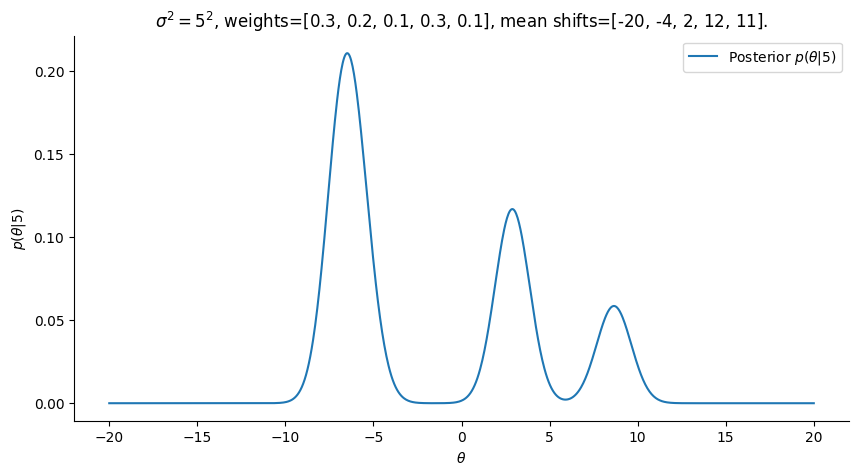

In [55]:
x_observed = 5
fig, ax = plt.subplots(figsize=(10,5))
label = fr"Posterior $p(\theta|{x_observed})$"
ax.plot(theta_range, posterior_pdf(theta_range, x_observed, weights, mean_shifts, sigma), label=label)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(fr"$p(\theta|{x_observed})$")
ax.set_title(fr"$\sigma^2 = {sigma}^2$, weights={weights}, mean shifts={mean_shifts}.")
plt.legend()

# ABC Posterior Approximations

## Rejection ABC

In [498]:
def model(theta):
    n = len(weights)
    component = np.random.choice(range(n), p=weights)
    return np.random.normal(loc=theta + mean_shifts[component], scale=1)

In [499]:
prior = scipy.stats.distributions.norm(0, sigma)
proposal = prior # Take proposal to be the prior for simplicity

In [500]:
def distance(x, x0):
    return abs(x - x0)

In [501]:
def ABC_RS(model, prior, distance, x_observed, n_samples, epsilon):
    accepted_samples = []
    n_iter = 0
    while len(accepted_samples) < n_samples:
        n_iter += 1
        theta_proposed = proposal.rvs().item()
        x_simulated = model(theta_proposed)
        if distance(x_simulated, x_observed) <= epsilon:
            accepted_samples.append(theta_proposed)
    print(fr"{n_samples} samples with epsilon = {epsilon} generated in {n_iter} iterations of ABC rejection sampling")
    return accepted_samples

In [502]:
n_samples = 1000
epsilon = 0.1
ABC_RS_samples = ABC_RS(model, prior, distance, x_observed=x_observed, n_samples=n_samples, epsilon=epsilon)

1000 samples with epsilon = 0.1 generated in 203763 iterations of ABC rejection sampling


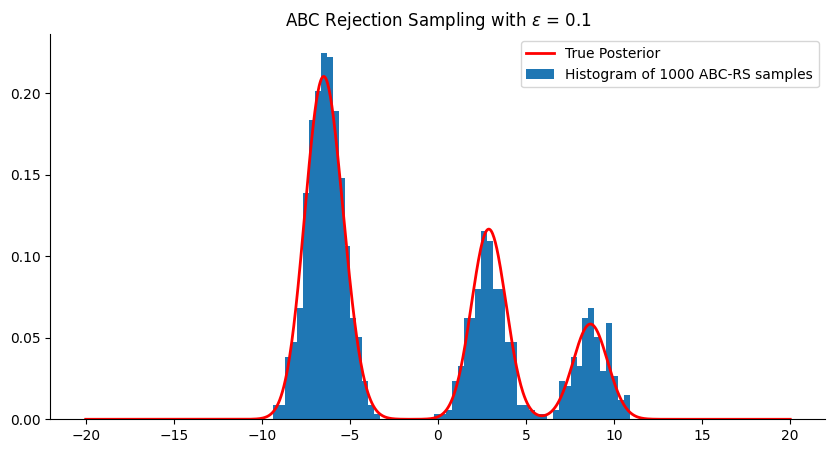

In [503]:
fig, ax = plt.subplots(figsize=(10,5))
# Plot true analytical posterior
ax.plot(theta_range, posterior_pdf(theta_range, x_observed, weights, mean_shifts), color="red", label="True Posterior", linewidth=2)
# Plot ABC-RS samples
ax.hist(ABC_RS_samples, density=True, bins=60, label=f"Histogram of {n_samples} ABC-RS samples")
ax.set_title(fr"ABC Rejection Sampling with $\epsilon$ = {epsilon}")
ax.legend()

In [ ]:
def abc_rs_sbc(model, prior, distance, n_samples=100, num_sbc_runs=100, epsilon=0.1):
    ranks = []
    for i in range(num_sbc_runs):
        prior_sample = prior.rvs() # Sample from prior.
        x_simulated = model(prior_sample) # Simulate a datapoint from the model given the prior sample.
        posterior_samples = np.array(ABC_RS(model, prior, distance, x_simulated, n_samples, epsilon)) # Numpy array of (n_samples, ) samples.
        rank = np.sum(prior_sample * np.ones_like(posterior_samples) > posterior_samples)/n_samples # Rank statistic
        ranks.append(float(rank))
    plt.hist(ranks, label=f"SBC rank histogram with {num_sbc_runs} SBC runs and {n_samples} samples per run.")
    plt.xlim(0, 1)
    plt.xlabel("Rank")
    plt.legend()
    plt.show()
    return ranks


50 samples with epsilon = 0.01 generated in 92713 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 82151 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 64935 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 229140 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 100889 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 112941 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 196470 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 117001 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 144001 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 230979 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 generated in 132921 iterations of ABC rejection sampling
50 samples with epsilon = 0.01 gene

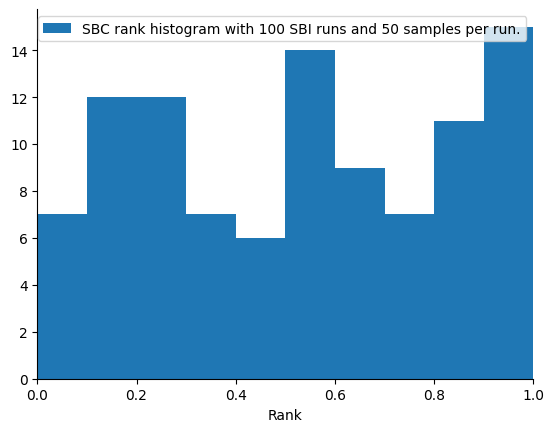

[0.68,
 0.98,
 1.0,
 0.94,
 0.22,
 0.46,
 0.74,
 0.14,
 0.78,
 0.38,
 0.16,
 0.1,
 0.5,
 0.64,
 0.84,
 0.22,
 0.78,
 0.52,
 0.42,
 0.08,
 0.56,
 0.92,
 0.36,
 0.32,
 0.52,
 0.72,
 0.56,
 0.36,
 0.06,
 0.04,
 0.48,
 0.22,
 0.18,
 0.82,
 0.32,
 0.3,
 0.14,
 1.0,
 0.98,
 0.16,
 0.94,
 0.08,
 0.98,
 0.62,
 0.46,
 0.78,
 0.56,
 0.84,
 0.8,
 0.3,
 0.52,
 0.28,
 0.18,
 0.22,
 0.28,
 0.58,
 0.52,
 0.88,
 0.18,
 0.56,
 0.98,
 0.0,
 0.58,
 0.2,
 0.3,
 0.44,
 0.8,
 0.68,
 0.74,
 0.62,
 0.26,
 0.9,
 0.58,
 1.0,
 0.04,
 0.34,
 0.12,
 0.82,
 0.6,
 0.44,
 0.8,
 0.8,
 0.14,
 0.92,
 0.86,
 0.96,
 0.12,
 0.92,
 1.0,
 0.38,
 0.68,
 0.66,
 0.2,
 0.84,
 0.12,
 0.54,
 0.64,
 0.0,
 0.62,
 0.78]

In [ ]:
abc_rs_sbc(model, prior, distance, n_samples=50, num_sbc_runs=100, epsilon=0.01)

## ABC-SMC

In [473]:
def model(parameter):
    n = len(weights)
    component = np.random.choice(range(n), p=weights)
    return {"data": np.random.normal(loc=parameter["theta"] + mean_shifts[component], scale=1)}

In [474]:
prior = pyabc.Distribution(theta=pyabc.RV("norm", 0, sigma))

In [475]:
def distance(x, x0):
    return abs(x["data"] - x0["data"])

In [366]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=1000)
db_path = os.path.join(tempfile.gettempdir(), "test.db")
abc.new("sqlite:///" + db_path, {"data": x_observed})
minimum_epsilon = 0.01
max_nr_populations = 10
history = abc.run(minimum_epsilon=minimum_epsilon, max_nr_populations=max_nr_populations)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2025-10-19 17:17:07>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 9.75305864e+00.
ABC INFO: Accepted: 1000 / 1993 = 5.0176e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 5.14385747e+00.
ABC INFO: Accepted: 1000 / 4185 = 2.3895e-01, ESS: 9.5167e+02.
ABC INFO: t: 2, eps: 2.80676299e+00.
ABC INFO: Accepted: 1000 / 6119 = 1.6343e-01, ESS: 8.4815e+02.
ABC INFO: t: 3, eps: 1.37935676e+00.
ABC INFO: Accepted: 1000 / 8875 = 1.1268e-01, ESS: 7.5609e+02.
ABC INFO: t: 4, eps: 6.92089381e-01.
ABC INFO: Accepted: 1000 / 14754 = 6.7778e-02, ESS: 6.2873e+02.
ABC INFO: t: 5, eps: 3.53031579e-01.
ABC INFO: Accepted: 1000 / 28171 = 3.5497e-02, ESS: 6.8057e+02.
ABC INFO: t: 6, eps: 1.69253953e-01.
ABC INFO: Accepted: 1000 / 56334 = 1.7751e-02, ESS: 6.1524e+02.
ABC INFO: t: 7, eps: 8.38794148e-02.
ABC INFO: Accepted: 1000 / 126833 = 7.8844e-03, ESS: 7.1373e+02.
ABC INFO: t: 8, eps: 4.39359178e-

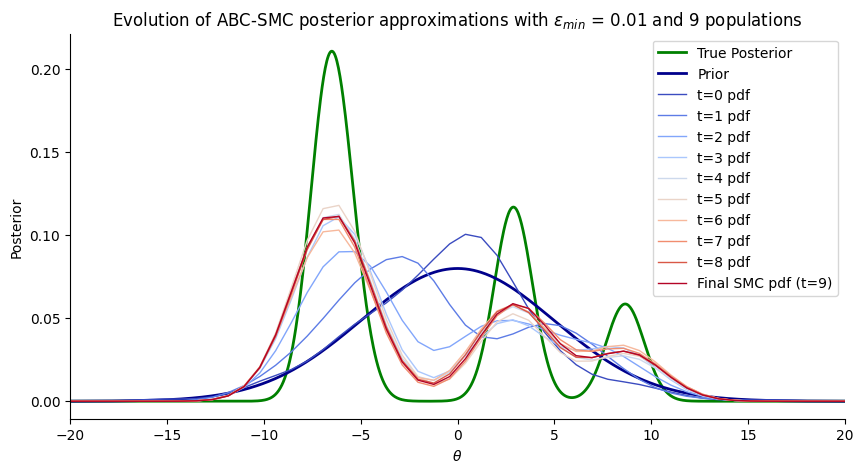

In [481]:
fig, ax = plt.subplots(figsize=(10,5))
# Plot true analytical posterior
ax.plot(theta_range, posterior_pdf(theta_range, x_observed, weights, mean_shifts), color="green", label="True Posterior", linewidth=2)
# Plot prior
ax.plot(theta_range, prior_pdf(theta_range), color='darkblue', label="Prior", linewidth=2)
# Colormap for plot color gradients across populations
cmap = plt.get_cmap("coolwarm")  # could change to "plasma", "coolwarm", etc.

for i, t in enumerate(np.arange(0, history.max_t + 1, 1, dtype=int)):
    color = cmap(i / history.max_t)  # map i to [0,1] for the colormap
    df, w = history.get_distribution(m=0, t=t)
    # Plots the Kernel Density Estimate (KDE) using the SMC-ABC samples and their weights. Mathematically, we must 
    # weight the samples using their SMC importance weights when calculating density estimates and expectations 
    # since it is the WEIGHTED versions that converge to the true posterior in the limit. 
    label = f"t={t} pdf" if i < history.max_t else f"Final SMC pdf (t={t})"  
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=theta_range[0],
        xmax=theta_range[-1],
        x="theta",
        xname=r"$\theta$",
        ax=ax,
        label=label,
        color=color,
        linewidth = 1
    )
ax.set_title(r"Evolution of ABC-SMC posterior approximations with $\epsilon_{min}$ = " + f"{minimum_epsilon} and {history.max_t} populations")
ax.legend();

Observe that, even with a small final epsilon value, the final generation ABCSMC posterior approximation is still overdispersed relative to the true posterior.

In [ ]:
def abc_smc_sbc(model, prior, distance, n_samples=100, num_sbc_runs=100, minimum_epsilon=0.1, max_nr_populations=10):
    abc = pyabc.ABCSMC(model, prior, distance, population_size=n_samples)
    db_path = os.path.join(tempfile.gettempdir(), "test.db") # String containing database path to store ABC_SMC runs
    ranks = []
    for i in range(num_sbc_runs):
        prior_sample = prior.rvs() # Sample from prior. Returns a pyabc <Parameter> object
        simulated_datapoint = model(prior_sample) # Simulate a datapoint from the model given the prior sample. Returns dict.
        abc.new("sqlite:///" + db_path, simulated_datapoint)
        history = abc.run(minimum_epsilon, max_nr_populations)
        posterior_samples = history.get_distribution()[0].to_numpy().flatten() # Numpy array of (n_samples, ) samples.
        posterior_sample_weights = history.get_distribution()[1]
        weighted_rank = np.dot(posterior_sample_weights, (next(iter(prior_sample.values())).item() * np.ones_like(posterior_samples) > posterior_samples)) # Weighted rank statistic
        ranks.append(float(weighted_rank))
    plt.hist(np. , ranks, label=f"SBC rank histogram with {num_sbc_runs} SBC runs and {n_samples} samples per run.")
    plt.xlim(0, 1)
    plt.xlabel("Rank")
    plt.legend()
    plt.show()
    return ranks


ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=9, start_time=2025-10-20 00:16:38>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.36266233e+01.
ABC INFO: Accepted: 50 / 91 = 5.4945e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 5.81288011e+00.
ABC INFO: Accepted: 50 / 297 = 1.6835e-01, ESS: 4.7919e+01.
ABC INFO: t: 2, eps: 3.33710488e+00.
ABC INFO: Accepted: 50 / 356 = 1.4045e-01, ESS: 4.5379e+01.
ABC INFO: t: 3, eps: 1.73160010e+00.
ABC INFO: Accepted: 50 / 518 = 9.6525e-02, ESS: 4.5888e+01.
ABC INFO: t: 4, eps: 9.25419605e-01.
ABC INFO: Accepted: 50 / 905 = 5.5249e-02, ESS: 4.2554e+01.
ABC INFO: t: 5, eps: 4.69624524e-01.
ABC INFO: Accepted: 50 / 1307 = 3.8256e-02, ESS: 4.2031e+01.
ABC INFO: t: 6, eps: 2.34996286e-01.
ABC INFO: Accepted: 50 / 4052 = 1.2340e-02, ESS: 4.2908e+01.
ABC INFO: t: 7, eps: 1.23377649e-01.
ABC INFO: Accepted: 50 / 7957 = 6.2838e-03, ESS: 4.3276e+01.
ABC INFO: t: 8, eps: 5.82479967e-02.
ABC INFO: Accepted: 50 

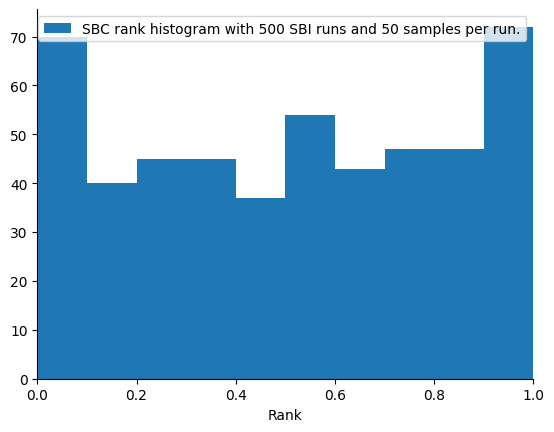

[0.0,
 0.5415832727454042,
 0.608136309234588,
 0.0,
 0.07963351956787865,
 0.9512820835058952,
 0.12934078694988055,
 0.6211756855791211,
 0.557419824393552,
 0.7402083295756807,
 0.7208764668056681,
 0.6856065115844421,
 0.38102466000698954,
 0.8382331821663915,
 0.6721517540071174,
 0.0,
 1.0,
 0.4048783686944455,
 0.45762763741991863,
 0.7975147243739473,
 0.8188621440992498,
 0.4273126553567679,
 0.5722625556426307,
 0.4886465714412974,
 0.8466389059124678,
 0.7065343687245234,
 0.6740611588417216,
 0.21656278618998784,
 0.44826384915312334,
 0.6460704156539674,
 0.058537167504017114,
 0.0,
 0.5559848235341561,
 0.4577753226949914,
 0.0,
 0.9999999999999998,
 1.0,
 0.376776569636872,
 0.2964222108409639,
 0.038003625850359816,
 0.5463747981200364,
 0.19437194593684756,
 0.6914152666415267,
 0.2393592357534754,
 0.9340533895001153,
 0.32243602233782265,
 0.0,
 0.2897024251292993,
 0.8505665875535865,
 1.0000000000000004,
 0.03311259289301213,
 0.4557448858928015,
 0.545212350790050

In [ ]:
abc_smc_sbc(model, prior, distance, n_samples=50, num_sbc_runs=500)